In [1]:
import numpy as np 
import pandas as pd 
import sys, requests, shutil, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import subplots

import glob
import warnings

import cv2

import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Lambda
from tensorflow.keras.optimizers import Adam, RMSprop

#from tensorflow.keras.applications.xception import Xception
#from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score

import tensorflow as tf
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

print('Keras version:', keras.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
warnings.simplefilter('default')

Keras version: 2.2.4-tf
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2778211489762222083
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10328006303209751539
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9464007490760427396
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11326753997
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9195567920091037959
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [2]:
#from tensorflow.keras.utils import multi_gpu_model

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

Using TensorFlow backend.


### data prep

In [4]:
mini_dataset_flag = False # set =True for debugging purpose
batch_size = 64
batch_size_predict = 256
input_shape = (150,150)
top_model_weights_path = "top-vgg16-model-weights.hdf5"
if mini_dataset_flag: top_model_weights_path = "mini-" + top_model_weights_path

load
1. n_cat
2. data_path
3. train_info
4. dev_info

In [5]:
n_cat = 6401
data_path = './datasets/train/'

h5_file_name = 'D0527-ex-rare60-reduce-top-labels-processed_data.h5'
if mini_dataset_flag: h5_file_name = 'mini-' + h5_file_name
data_load = pd.HDFStore(h5_file_name)
train_info = data_load['train_info']
dev_info = data_load['dev_info']
data_load.close()

/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [6]:
print(len(train_info))
train_info.head()

932274


,url,landmark_id,filename,label,one_hot
id,,,,,
49567a7236b170ba,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/49567a7236b170ba.jpg,0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
350c35dd0e716f5d,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/350c35dd0e716f5d.jpg,0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
c74313b74dd3195d,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/c74313b74dd3195d.jpg,0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
8323df4b0689d343,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/8323df4b0689d343.jpg,0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."
5ffdeed07f56f8aa,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/5ffdeed07f56f8aa.jpg,0,"(0, 0)\t1.0\n (1, 0)\t1.0\n (2, 0)\t1.0\n ..."


In [7]:
print(len(dev_info))
dev_info.head()

233026


,url,landmark_id,filename
id,,,
ed7a897e2b7977ee,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/ed7a897e2b7977ee.jpg
70fa6dfd6ae8fa0a,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/70fa6dfd6ae8fa0a.jpg
083f4ecd174e5114,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/083f4ecd174e5114.jpg
1aced71eaac3a0bb,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/1aced71eaac3a0bb.jpg
bafe7a417b7bc113,https://upload.wikimedia.org/wikipedia/commons...,27,./datasets/train/bafe7a417b7bc113.jpg


In [8]:
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=True, n_values=n_cat)
label_encoder.fit_transform(train_info['landmark_id'].values)
one_hot_encoder.fit_transform(train_info['label'].values.reshape(-1, 1))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)


<932274x6401 sparse matrix of type '<class 'numpy.float64'>'
	with 932274 stored elements in Compressed Sparse Row format>

### ImageNet info

In [9]:
model =VGG16(weights = 'imagenet', include_top = True)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_ops.py:60: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  elif not isinstance(value, collections.Sized):


/opt/anaconda3/lib/python3.7/site-packages/keras/preprocessing/image.py:43: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  if 'dtype' in inspect.getargspec(image.img_to_array).args:


Predicted: [('n02825657', 'bell_cote', 0.24031775), ('n03697007', 'lumbermill', 0.082326174), ('n04523525', 'vault', 0.072314225)]


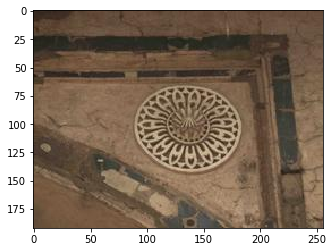

In [10]:
img_path = r'./datasets/train/8323df4b0689d343.jpg'
img = image.load_img(img_path, target_size= (224,224))
testimg = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
plt.imshow(testimg)
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

preds = model.predict(x)
print ('Predicted:', decode_predictions(preds, top = 3)[0])

### Image i/o and image data augmentaition

In [11]:
def load_images(info, input_shape = input_shape):
    input_shape = tuple(input_shape)
    imgs = np.zeros((len(info), input_shape[0], input_shape[1], 3))

    for i in range(len(info)):
        fname = info.iloc[i]['filename']
        try:
            img = cv2.cvtColor(
                  cv2.resize(cv2.imread(fname),input_shape),
                  cv2.COLOR_BGR2RGB)
        except:
            warnings.warn('Warning: could not read image: '+ fname +
                          '. Use black img instead.')
            img = np.zeros((input_shape[0], input_shape[1], 3))
        imgs[i,:,:,:] = img
    
    return imgs

In [12]:
def load_cropped_images(info, crop_p=0.2, crop='random'):
    new_res = np.array([int(input_shape[0]*(1+crop_p)), int(input_shape[1]*(1+crop_p))])
    if crop == 'random':
        cx0 = np.random.randint(new_res[0] - input_shape[0], size=len(info))
        cy0 = np.random.randint(new_res[1] - input_shape[1], size=len(info))
    else:
        if crop == 'central':
            cx0, cy0 = (new_res - input_shape) // 2                
        if crop == 'upper left':
            cx0, cy0 = 0, 0
        if crop == 'upper right':
            cx0, cy0 = new_res[1] - input_shape[1], 0
        if crop == 'lower left':
            cx0, cy0 = 0, new_res[0] - input_shape[0]
        if crop=='lower right':
            cx0, cy0 = new_res - input_shape        
        cx0 = np.repeat(np.expand_dims(cx0, 0), len(info))
        cy0 = np.repeat(np.expand_dims(cy0, 0), len(info))

    cx1 = cx0 + input_shape[0]
    cy1 = cy0 + input_shape[1]
    
    raw_imgs = load_images(info, input_shape=tuple(new_res))
    
    cropped_imgs = np.zeros((len(info), input_shape[0], input_shape[1], 3))
    for ind in range(len(info)):
        cropped_imgs[ind,:,:,:] = raw_imgs[ind,
                                           cy0[ind]:cy1[ind],
                                           cx0[ind]:cx1[ind], :]
    
    return cropped_imgs

In [13]:
def get_image_gen(info_arg, 
                  shuffle=True, 
                  image_aug=True, 
                  eq_dist=False, 
                  n_ref_imgs=16, 
                  crop_prob=0.5, 
                  crop_p=0.5,
                 batch_size = 256):
    if image_aug:
        datagen = ImageDataGenerator(
            rotation_range=4.,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.5,
            channel_shift_range=25,
            horizontal_flip=True,
            fill_mode='nearest')
        
        if crop_prob > 0:
            datagen_crop = ImageDataGenerator(
                rotation_range=4.,
                shear_range=0.2,
                zoom_range=0.1,
                channel_shift_range=20,
                horizontal_flip=True,
                fill_mode='nearest')
        
    count = len(info_arg)
    while True:
        if eq_dist:
            def sample(df):
                return df.sample(min(n_ref_imgs, len(df)))
            info = info_arg.groupby('landmark_id', group_keys=False).apply(sample)
        else:
            info = info_arg
        print('Generate', len(info), 'for the next round.')
        
        #shuffle data
        if shuffle and count >= len(info):
            info = info.sample(frac=1)
            count = 0
            
        # load images
        for ind in range(0,len(info), batch_size):
            count += batch_size

            y = info['landmark_id'].values[ind:(ind+batch_size)]
            
            if np.random.rand() < crop_prob:
                imgs = load_cropped_images(info.iloc[ind:(ind+batch_size)], 
                                           crop_p=crop_p*np.random.rand() + 0.01, 
                                           crop='random')
                if image_aug:
                    cflow = datagen_crop.flow(imgs, 
                                              y, 
                                              batch_size=imgs.shape[0], 
                                              shuffle=False)
                    imgs, y = next(cflow)                    
            else:
                imgs = load_images(info.iloc[ind:(ind+batch_size)])
                if image_aug:
                    cflow = datagen.flow(imgs, 
                                       y, 
                                       batch_size=imgs.shape[0], 
                                       shuffle=False)
                    imgs, y = next(cflow)             

            imgs = preprocess_input(imgs)
    
            y_l = label_encoder.transform(y[y>=0.])        
            y_oh = np.zeros((len(y), n_cat))
            y_oh[y >= 0., :] = one_hot_encoder.transform(y_l.reshape(-1,1)).todense()
                    
            yield imgs, y_oh

In [14]:
train_gen = get_image_gen(train_info , 
                          image_aug = True,
                          eq_dist=False, 
                          n_ref_imgs=50, 
                          crop_prob=0, 
                          crop_p=0,
                          batch_size = batch_size)

In [15]:
X_example, y_example = next(train_gen)
#plt.imshow(X_example[1,:,:,:]/2. + 0.5)
#plt.imshow(tt)

Generate 932274 for the next round.


/opt/anaconda3/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


In [16]:
validation_gen = get_image_gen(dev_info, 
                          image_aug = False,
                          eq_dist=False, 
                          crop_prob=0, 
                          crop_p=0,
                          batch_size = batch_size)

In [17]:
y_example

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### The model

In [18]:

def batch_GAP(y_t, y_p):
    pred_cat = tf.argmax(y_p, axis=-1)    
    y_t_cat = tf.argmax(y_t, axis=-1) * tf.cast(
        tf.reduce_sum(y_t, axis=-1), tf.int64)
    
    n_pred = tf.shape(pred_cat)[0]
    is_c = tf.cast(tf.equal(pred_cat, y_t_cat), tf.float32)

    GAP = tf.reduce_mean(
          tf.cumsum(is_c) * is_c / tf.cast(
              tf.range(1, n_pred + 1), 
              dtype=tf.float32))
    
    return GAP

In [ ]:
K.clear_session()

In [ ]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=list(input_shape) + [3])
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dense(n_cat, activation='softmax'))

In [ ]:
model = Model(inputs= base_model.input, outputs= top_model(base_model.output))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
for layer in model.layers[:16]:    
    if mini_dataset_flag: 
        layer.trainable = False
    else: 
        layer.trainable = False
# compile the model with a SGD/momentum optimizer and a very slow learning rate.
model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.0005),
                  metrics=['accuracy', batch_GAP])
print ('Compilation done.')
model.summary()

Compilation done.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37,

In [ ]:
weights_path = './top-vgg16-model-weights.hdf5'
model.load_weights(weights_path)

In [ ]:
checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
callbacks_list = [checkpoint]
np.warnings.filterwarnings('ignore')

In [ ]:
model.fit_generator(train_gen, 
                    steps_per_epoch=len(train_info) // batch_size/2, 
                    epochs=30, 
                    validation_data=validation_gen,
                    validation_steps=len(dev_info) // batch_size/4,
                    callbacks=callbacks_list,
                   use_multiprocessing=False)

Epoch 1/30
7282/7283 [============================>.] - ETA: 0s - loss: 6.7167 - accuracy: 0.0410 - batch_GAP: 0.0047Generate 233026 for the next round.

Epoch 00001: val_accuracy improved from -inf to 0.04420, saving model to top-vgg16-model-weights.hdf5
7283/7283 [==============================] - 4006s 550ms/step - loss: 6.7167 - accuracy: 0.0410 - batch_GAP: 0.0047 - val_loss: 6.7301 - val_accuracy: 0.0442 - val_batch_GAP: 0.0052
Epoch 2/30
7282/7283 [============================>.] - ETA: 0s - loss: 6.8458 - accuracy: 0.0349 - batch_GAP: 0.0037Generate 932274 for the next round.

Epoch 00002: val_accuracy improved from 0.04420 to 0.04456, saving model to top-vgg16-model-weights.hdf5
7283/7283 [==============================] - 3915s 538ms/step - loss: 6.8458 - accuracy: 0.0349 - batch_GAP: 0.0037 - val_loss: 6.7377 - val_accuracy: 0.0446 - val_batch_GAP: 0.0051
Epoch 3/30
7282/7283 [============================>.] - ETA: 0s - loss: 6.7430 - accuracy: 0.0371 - batch_GAP: 0.0040
Epo

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.xlabel('epoch')
plt.ylabel('loss')